# Analiza danych z pliku tekstowego Cell_Phones_&_Accessories.txt
***
# 1 Cel zadania
Celem w zadaniu jest analiza danych z pliku tekstowego Cell_Phones_&_Accessories.txt oraz uzyskanie z niego jak największej ilości informacji.
# 2 Propozycje informacji które można uzyskać z tekstu
- Ilu gwiazdkom odpowiada dana recenzja? Na podstawie tekstu recenzji zostanie wygenerowana jej ocena w skali(1-5). (w tym notatniku)
- Generator krótkiego podsumowania na podstawie tekstu recenzji. (w notatniku 2)
- Analiza statystyczna danych. Bez Machine Learningu. (w notatniku 3)
# Uwaga
Komentarze we fragmentach kodu pisane są w języku angielskim

## Pierwszym zadaniem będzie stworzenie sieci neuronowej która będzie w stanie ocenić czy recenzja jest pozytywna, czy negatywna

Zakładam, że punktowa skala ocen w danych wejściowych (1-5) jest miarodajnym źródłem informacji na temat tego, czy dana ocena produktu jest pozytywna. Potraktuję zatem pola "review/score" jako źródło 'etykiet' (ang. *labels*) dla zaporoponowanej przeze mnie sieci neuronowej. Wejściem sieci będzie natomiast tekst recenzji. Sieć generować będzie proponowaną ocenę na podstawie tekstu recenzji.

Tutaj dołączmy potrzebne biblioteki i zdefiniujmy wykorzystywane później stałe

In [1]:
from __future__ import annotations
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import shutil
import numpy as np
import os
import random
import pickle
from common.data_loader import file_loader, DataGeneratorStars # Tools to manipulate data
from common.preprocess import preprocess_stars

# If they dont exist create them
try:
    os.mkdir('models') 
except:
    pass
try:
    os.mkdir('img')
except:
    pass
try:
    os.mkdir('results')
except:
    pass


# Name of an input file
phones_file_name: str = "source/Cell_Phones_&_Accessories.txt"
# Vocabulary size
max_words = 20000
# Review size
max_len = 500
# Batch size
batch_size = 32

Sprawdźmy na początek ile danych w pliku mamy do dyspozycji. Będzie to przydatne przy dzieleniu recenzji na zbiory: treningowy, testowy oraz walidacyjny.

In [2]:
i:int = 0
for data in file_loader(phones_file_name):
    if data != {}:
        i+=1
print(i)

78930


Jak widać mamy 78930 unikalnych wpisów. Załóżmy że około 80% danych to zbiór treningowy, 10% zbiór treningowy, 10% zbiór walidacyjny. Zatem będziemy mieli 64000 recenzji treningowych, 8000 testowych, a reszta to zbiór walidacyjny. Żeby nie obiążać pamięci komputera skorzystamy z generatora danych treningowych, testowych oraz walidacyjnych. W tym celu przetwórzmy najpierw plik testowy do tablic numpy.

In [3]:
preprocess_stars(phones_file_name)

Tablice zapisane są w katalogu "source". Zainicjumy zatem generator który będzie z nich korzystał

In [4]:
# Initialize data generators
train_gen = DataGeneratorStars(0, 64000, batch_size=batch_size,
                                max_words=max_words, max_review_size=max_len)

test_gen = DataGeneratorStars(64000, 72000, batch_size=batch_size,
                                max_words=max_words, max_review_size=max_len)

val_gen = DataGeneratorStars(72000, 78930, batch_size=batch_size,
                                max_words=max_words, max_review_size=max_len)

Zadanie zacznijmy od napisania algorytmu który sprawdzi linię bazowa dla problemu. Skoro wartości znormalizowanych ocen mogą przyjąć wartości $0$, $0.25$, $0.5$, $0.75$, $1.0$, to najmniejszy błąd predykcji, wybierając średnią z danych testowych. Policzmy ją i wstawmy ją do prostej funkcji

In [5]:
sum: float = 0
for i in range(len(test_gen)):
    sum += np.sum(train_gen.__getitem__(i)[1])
baseline = sum/(len(test_gen)*batch_size)

def my_mae(test_gen: generator, baseline: float) -> float:
    maes:list = []
    mae:float
    for i in range(len(test_gen)):
        mae = np.mean(np.abs(baseline - train_gen.__getitem__(i)[1]))
        maes.append(mae)
    return np.mean(maes)
    
print(my_mae(test_gen, baseline))

0.3322742734375


Otrzymujemy informację, że ślepo podążając takim naiwnym rozwiązaniem otrzymujemy średnio błąd na poziomie $0.33$. Wszystko co da błąd mniejszy niż ta wartość można uznać że jest już w jakimś stopniu inteligentne :)

Dane są teraz w idealnej postaci do przekazania ich do warstwy osadzającej *embedding*. Dzięki niej modelować będziemy mogli modelować subtelne zależności między słowami.

Stwórzmy prostą sieć, która postara się wykonać zadanie regresji.

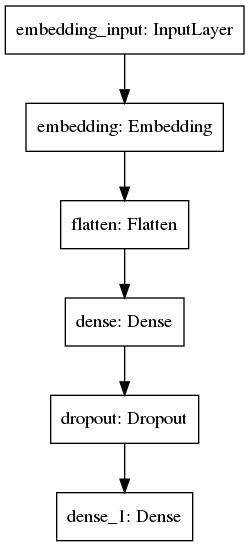

In [6]:
# Create sequential model of network. It's just simple model to check if it works somehow
model_simple = Sequential(name="simple")
model_simple.add(Embedding(max_words, 128, input_length=max_len)) # n x max_len x 512 
model_simple.add(Flatten()) # n x max_len*512
model_simple.add(Dense(32, activation='relu'))
model_simple.add(Dropout(0.5))
model_simple.add(Dense(1, activation='sigmoid'))
model_simple.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=["mae"])
plot_model(model_simple, to_file='img/model_simple.png')

In [7]:
# Train our model
try:
    shutil.rmtree('results/simple')
except:
    pass

os.mkdir('results/simple')

callbacks = [TensorBoard(log_dir='results/simple', histogram_freq=1, embeddings_freq=1)]

history = model_simple.fit(train_gen,
                           epochs=5, batch_size=batch_size,
                           validation_data=val_gen,
                           callbacks = callbacks)

model_simple.save_weights("models/simple.h5")

Epoch 1/5
   1/2000 [..............................] - ETA: 0s - loss: 0.1811 - mae: 0.3911WARNING:tensorflow:From /home/patryk/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2000/2000 [==============================] - 40s 20ms/step - loss: 0.0844 - mae: 0.2249 - val_loss: 0.0626 - val_mae: 0.1814
Epoch 2/5
2000/2000 [==============================] - 29s 15ms/step - loss: 0.0505 - mae: 0.1575 - val_loss: 0.0633 - val_mae: 0.1713
Epoch 3/5
2000/2000 [==============================] - 30s 15ms/step - loss: 0.0373 - mae: 0.1301 - val_loss: 0.0648 - val_mae: 0.1723
Epoch 4/5
2000/2000 [==============================] - 30s 15ms/step - loss: 0.0284 - mae: 0.1101 - val_loss: 0.0664 - val_mae: 0.1751
Epoch 5/5
2000/2000 [==============================] - 30s 15ms/step - loss: 0.0234 - mae

250/250 [==============================] - 2s 10ms/step - loss: 0.0756 - mae: 0.1865
[0.07561386376619339, 0.18647268414497375]


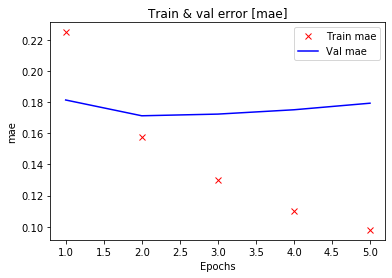

In [8]:
# Evaluate model
print(model_simple.evaluate(test_gen))

acc = history.history['mae']
val_acc = history.history['val_mae']

plt.plot(range(1, len(acc)+1), acc, 'rx', label='Train mae')
plt.plot(range(1, len(acc)+1), val_acc, 'b', label='Val mae')
plt.title('Train & val error [mae]')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

Stwórzmy teraz prostą sieć rekurencyjną z warstwa LSTM

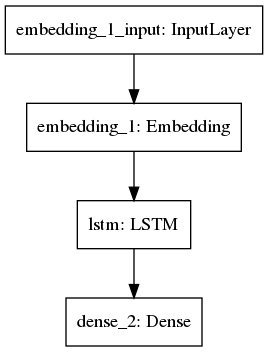

In [9]:
# Create reccurent network
model_LSTM = Sequential(name="lstm")
model_LSTM.add(Embedding(max_words, 128, input_length=max_len))
model_LSTM.add(LSTM(64, dropout=0.2))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=["mae"])
plot_model(model_LSTM, to_file='img/model_LSTM.png')

In [10]:
# Train LSTM network
try:
    shutil.rmtree('results/lstm')
except:
    pass

os.mkdir('results/lstm')

callbacks = [TensorBoard(log_dir='results/lstm', histogram_freq=1, embeddings_freq=1)]

history_LSTM = model_LSTM.fit(train_gen,
                              epochs=10, batch_size=batch_size,
                              validation_data=val_gen,
                              callbacks = callbacks)
model_LSTM.save_weights("models/lstm.h5")


Epoch 1/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.0716 - mae: 0.2084 - val_loss: 0.0595 - val_mae: 0.1812
Epoch 2/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.0529 - mae: 0.1729 - val_loss: 0.0534 - val_mae: 0.1710
Epoch 3/10
2000/2000 [==============================] - 53s 26ms/step - loss: 0.0462 - mae: 0.1580 - val_loss: 0.0530 - val_mae: 0.1652
Epoch 4/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.0411 - mae: 0.1468 - val_loss: 0.0483 - val_mae: 0.1558
Epoch 5/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.0375 - mae: 0.1383 - val_loss: 0.0471 - val_mae: 0.1575
Epoch 6/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.0338 - mae: 0.1296 - val_loss: 0.0491 - val_mae: 0.1580
Epoch 7/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.0311 - mae: 0.1226 - val_loss: 0.0466 - val_mae: 0.1534
Epoch 8/10
2000/2000 [==========================

250/250 [==============================] - 2s 9ms/step - loss: 0.0528 - mae: 0.1606
[0.052827320992946625, 0.1605658382177353]


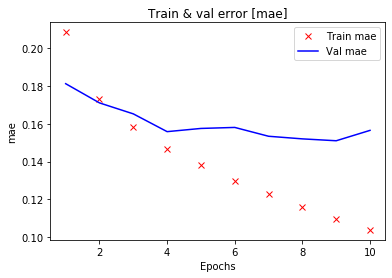

In [11]:
# Evaluate LSTM network
print(model_LSTM.evaluate(test_gen))

acc = history_LSTM.history['mae']
val_acc = history_LSTM.history['val_mae']

plt.plot(range(1, len(acc)+1), acc, 'rx', label='Train mae')
plt.plot(range(1, len(acc)+1), val_acc, 'b', label='Val mae')
plt.title('Train & val error [mae]')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

Zobaczmy jak działa dla naszego przykładu dwukierunkowa sieć rekurencyjna

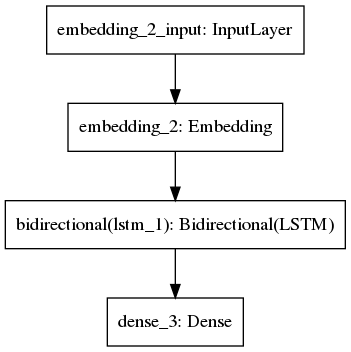

In [12]:
# Create network
model_LSTM2 = Sequential(name="lstm2")
model_LSTM2.add(Embedding(max_words, 128, input_length=max_len))
model_LSTM2.add(Bidirectional(LSTM(64, dropout=0.2)))
model_LSTM2.add(Dense(1, activation='sigmoid'))
model_LSTM2.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=["mae"])
plot_model(model_LSTM2, to_file='img/model_LSTM2.png') 

In [13]:
# Train network
try:
    shutil.rmtree('results/lstm2')
except:
    pass

os.mkdir('results/lstm2')

callbacks = [TensorBoard(log_dir='results/lstm2', histogram_freq=1, embeddings_freq=1)]

history_LSTM2 = model_LSTM2.fit(train_gen,
                                epochs=10, batch_size=batch_size,
                                validation_data=val_gen,
                                callbacks = callbacks)
model_LSTM2.save_weights("models/lstm2.h5")

Epoch 1/10
2000/2000 [==============================] - 83s 41ms/step - loss: 0.0715 - mae: 0.2089 - val_loss: 0.0934 - val_mae: 0.2357
Epoch 2/10
2000/2000 [==============================] - 82s 41ms/step - loss: 0.0530 - mae: 0.1735 - val_loss: 0.0530 - val_mae: 0.1712
Epoch 3/10
2000/2000 [==============================] - 84s 42ms/step - loss: 0.0460 - mae: 0.1585 - val_loss: 0.0485 - val_mae: 0.1643
Epoch 4/10
2000/2000 [==============================] - 83s 42ms/step - loss: 0.0412 - mae: 0.1474 - val_loss: 0.0529 - val_mae: 0.1635
Epoch 5/10
2000/2000 [==============================] - 84s 42ms/step - loss: 0.0371 - mae: 0.1382 - val_loss: 0.0485 - val_mae: 0.1600
Epoch 6/10
2000/2000 [==============================] - 84s 42ms/step - loss: 0.0340 - mae: 0.1304 - val_loss: 0.0495 - val_mae: 0.1544
Epoch 7/10
2000/2000 [==============================] - 82s 41ms/step - loss: 0.0309 - mae: 0.1225 - val_loss: 0.0457 - val_mae: 0.1508
Epoch 8/10
2000/2000 [==========================

250/250 [==============================] - 3s 13ms/step - loss: 0.0507 - mae: 0.1583
[0.05070784315466881, 0.15832319855690002]


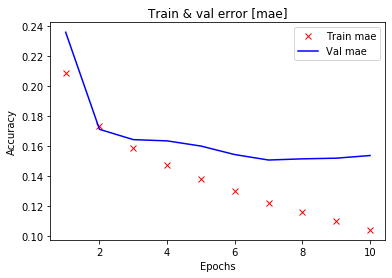

In [14]:
# Evaluate network
print(model_LSTM2.evaluate(test_gen))
                            
acc = history_LSTM2.history['mae']
val_acc = history_LSTM2.history['val_mae']

plt.plot(range(1, len(acc)+1), acc, 'rx', label='Train mae')
plt.plot(range(1, len(acc)+1), val_acc, 'b', label='Val mae')
plt.title('Train & val error [mae]')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()         

Może jednowymiarowa sieć konwolucyjna da radę dokonać lepszej predykcji

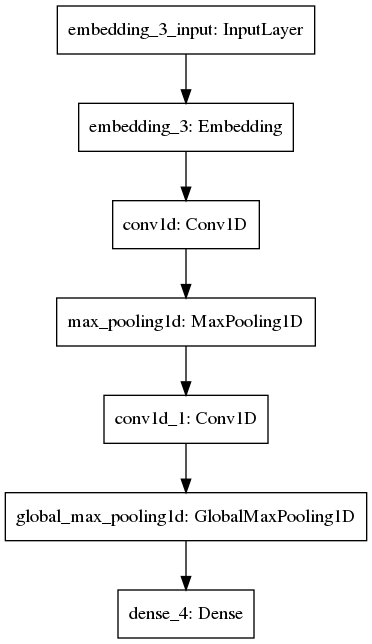

In [15]:
# Create model
model_CONV = Sequential(name="conv")
model_CONV.add(Embedding(max_words, 128, input_length=max_len))
model_CONV.add(Conv1D(32, 5, activation='relu'))
model_CONV.add(MaxPooling1D(5))
model_CONV.add(Conv1D(32, 5, activation='relu'))
model_CONV.add(GlobalMaxPool1D())
model_CONV.add(Dense(1, activation='sigmoid'))
model_CONV.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=["mae"])
plot_model(model_CONV, to_file='img/model_CONV.png') 

In [16]:
# Train network
try:
    shutil.rmtree('results/conv')
except:
    pass

os.mkdir('results/conv')

callbacks = [TensorBoard(log_dir='results/conv', histogram_freq=1, embeddings_freq=1)]

history_CONV = model_CONV.fit(train_gen,
                               epochs=7, batch_size=batch_size,
                               validation_data=val_gen,
                               callbacks = callbacks)
model_CONV.save_weights("models/conv.h5") 

Epoch 1/7
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0677 - mae: 0.1996 - val_loss: 0.0534 - val_mae: 0.1728
Epoch 2/7
2000/2000 [==============================] - 28s 14ms/step - loss: 0.0469 - mae: 0.1605 - val_loss: 0.0541 - val_mae: 0.1682
Epoch 3/7
2000/2000 [==============================] - 28s 14ms/step - loss: 0.0381 - mae: 0.1424 - val_loss: 0.0504 - val_mae: 0.1612
Epoch 4/7
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0305 - mae: 0.1259 - val_loss: 0.0524 - val_mae: 0.1679
Epoch 5/7
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0242 - mae: 0.1108 - val_loss: 0.0542 - val_mae: 0.1688
Epoch 6/7
2000/2000 [==============================] - 28s 14ms/step - loss: 0.0197 - mae: 0.0996 - val_loss: 0.0554 - val_mae: 0.1695
Epoch 7/7
2000/2000 [==============================] - 29s 14ms/step - loss: 0.0165 - mae: 0.0908 - val_loss: 0.0575 - val_mae: 0.1701


250/250 [==============================] - 2s 9ms/step - loss: 0.0587 - mae: 0.1728
[0.0587286576628685, 0.1727522760629654]


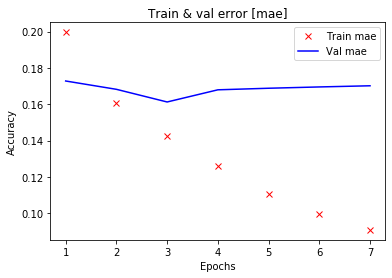

In [17]:
# Evaluate network
print(model_CONV.evaluate(test_gen))
                            
acc = history_CONV.history['mae']
val_acc = history_CONV.history['val_mae']

plt.plot(range(1, len(acc)+1), acc, 'rx', label='Train mae')
plt.plot(range(1, len(acc)+1), val_acc, 'b', label='Val mae')
plt.title('Train & val error [mae]')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()                      

Najlepsze rezulaty zdaje się oferować jedna z sieci reukrurencyjnych. Sprawdźmy ocenę modelu dla napisanych przeze mnie recenzji.

In [18]:
# An example
my_review_negative:list = ["This phone is bad"]
my_review_positive:list = ["It is an excelent, good phone"]

with open('source/stars/tokenizer.pickle', 'rb') as file:
    my_tokenizer = pickle.load(file)

# Just some preparations
review_data_negative = my_tokenizer.texts_to_sequences(my_review_negative)
review_data_negative = pad_sequences(review_data_negative, maxlen = max_len)

review_data_positive = my_tokenizer.texts_to_sequences(my_review_positive)
review_data_positive = pad_sequences(review_data_positive, maxlen = max_len)

print(model_LSTM.predict(review_data_negative)*4+1)
print(model_LSTM.predict(review_data_positive)*4+1)

[[1.5449114]]
[[4.546241]]


Jak widać użycie słów negatywnych działa wybornie w tym przykładzie. Algorytm ocenił go na około 1.55 gwiazdki. Użycie słów polecających również działa tak jak ma działać ocena to około 4.55 gwiazdki.